In [1]:
# read dataset pascal
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as scio
import sys
#print(sys.path)
sys.path.insert(0, '../')
from dpl import utils
from dpl.data.pascal import preprocessing

import keras
import multiprocessing
# 标签数据预处理
#preprocessing.split_label_into_masks("/home/super-workstation/Data/pascal/VOC_Data/VOC2012/SegmentationClass", "/mask1/")

import os
import cv2
    
from voc_data_generator import *
from voc_data_generator_v2 import *

image_root = "/home/super-workstation/Data/pascal/VOC_Data/VOC2012/"
path = image_root
# v1 get image and label
import yaml
with open("init_args.yml", 'r') as stream:
    try:
        init_args = yaml.load(stream)
    except yaml.YAMLError as exc:
        print(exc)

datagen = PascalVocGenerator(image_shape=[224, 224, 3],
                             image_resample=True,
                             pixelwise_center=True,
                             pixel_mean=[115.85100, 110.50989, 102.16182],
                             pixelwise_std_normalization=True,
                             pixel_std=[70.30930, 69.41244, 72.60676])

train_loader = ImageSetLoader(**init_args['image_set_loader']['train'])
val_loader = ImageSetLoader(**init_args['image_set_loader']['val'])
val_gen = datagen.flow_from_imageset(
        class_mode='categorical',
        classes=21,
        batch_size=5,
        shuffle=False,
        image_set_loader=val_loader)
batch = next(val_gen)
batch = next(val_gen)
utils.showSingleImage(batch[0][0])
utils.showSingleImage(batch[1][0,:,:,17])

# v2 get image and label
config = Config()
config.batch_size = 5
config.steps_per_epoch = 180
config.validation_steps = 40
config.shuffle=False
train_dataset = PascalDataset(path, is_train=True)
val_dataset = PascalDataset(path, is_train=False)

train_gen = data_generator(train_dataset, config)
val_gen = data_generator(val_dataset, config)

img_label = next(val_gen)
img_label = next(val_gen)
#print(img_label[1].shape)
utils.showSingleImage(img_label[0][0])
utils.showSingleImage(img_label[1][0,:,:,17])

#print(img_label[0][0][100:200,:])

Using TensorFlow backend.
/home/super-workstation/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/super-workstation/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/super-workstation/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/super-workstation/.local/l

info:
image size -->  224 x 224
channels -->  3


<Figure size 640x480 with 1 Axes>

info:
image size -->  224 x 224


<Figure size 640x480 with 1 Axes>

info:
image size -->  512 x 512
channels -->  3


<Figure size 640x480 with 1 Axes>

info:
image size -->  512 x 512


<Figure size 640x480 with 1 Axes>

In [2]:
# fcn 32s
# 直接从 pool5 上采样（反卷级）到原尺寸
# 5 layers
from keras.models import Model, Sequential
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, UpSampling2D
from keras.layers import Input, ZeroPadding2D, BatchNormalization, Activation

def conv2d_bn(input, nums_kernal, size, strides=1, padding = 'same'):
    x = Conv2D(nums_kernal, size, padding=padding, strides=strides)(input)
    #x = BatchNormalization()(x)
    return Activation('relu')(x)

def create_fcn32(input_size=(512,512,3)):
    # model = Sequential()
    # preprocessing
    input = Input(shape=(input_size))
    #x = ZeroPadding2D(100)(input)
    # layer1 2conv  1/2
    x = conv2d_bn(input, 64, (3,3))
    x = conv2d_bn(x, 64, (3,3))
    pool1 = MaxPooling2D()(x)

    # layer2 2conv 1/4
    x = conv2d_bn(pool1, 128, (3,3))
    x = conv2d_bn(x, 128, (3,3))
    pool2 = MaxPooling2D()(x)

    # layer3 3conv 1/8
    x = conv2d_bn(pool2, 256, (3,3))
    x = conv2d_bn(x, 256, (3,3))
    x = conv2d_bn(x, 256, (3,3))
    pool3 = MaxPooling2D()(x)

    # layer4 3conv 1/16
    x = conv2d_bn(pool3, 512, (3,3))
    x = conv2d_bn(x, 512, (3,3))
    x = conv2d_bn(x, 512, (3,3))
    pool4 = MaxPooling2D()(x)

    # layer5 3conv 1/32
    x = conv2d_bn(pool4, 512, (3,3))
    x = conv2d_bn(x, 512, (3,3))
    x = conv2d_bn(x, 512, (3,3))
    pool5 = MaxPooling2D()(x)

    # layer6 2full
    full_1 = conv2d_bn(pool5, 4096, (7,7))
    drop_1 = Dropout(0.5)(full_1)
    full_2 = conv2d_bn(drop_1, 4096, (1,1))
    drop_2 = Dropout(0.5)(full_2)

    # 上采样32倍
    drop_2_n = conv2d_bn(drop_1, 21, (1,1), padding='valid')
    #deconv_1 = Conv2DTranspose(21, (64,64), strides=32)(drop_2_n)

    ratio = (int(input.shape[1].value/drop_2_n.shape[1].value), int(input.shape[2].value/drop_2_n.shape[2].value))
    print(ratio)
    bilinear_inter_1 = UpSampling2D(ratio)(drop_2_n)
    deconv_1 = conv2d_bn(bilinear_inter_1, 21, (3,3))

    output=Activation('softmax')(deconv_1)

    model = Model(input, output, name='fcn_net')
    return model

model = create_fcn32((512, 512, 3))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
        

W0903 16:04:14.159532 140494861784896 deprecation_wrapper.py:119] From /home/super-workstation/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0903 16:04:14.168361 140494861784896 deprecation_wrapper.py:119] From /home/super-workstation/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0903 16:04:14.170025 140494861784896 deprecation_wrapper.py:119] From /home/super-workstation/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0903 16:04:14.185495 140494861784896 deprecation_wrapper.py:119] From /home/super-workstation/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf

(32, 32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 64)      1792      
_________________________________________________________________
activation_1 (Activation)    (None, 512, 512, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
activation_2 (Activation)    (None, 512, 512, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 128)     73856     
_

In [13]:
optimizer = keras.optimizers.Adam(1e-4)
model = create_fcn32((224, 224, 3))
# model.summary()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(
    datagen.flow_from_imageset(
        class_mode='categorical',
        classes=21,
        batch_size=5,
        shuffle=True,
        image_set_loader=train_loader),
    steps_per_epoch=500,
    epochs=1,
    verbose=1,
    use_multiprocessing=False)

(32, 32)
Epoch 1/10
214/500 [===========>..................] - ETA: 1:24 - loss: 1.4426 - acc: 0.7418

KeyboardInterrupt: 

In [3]:
#utils.get_model_memory_usage(10, model)
#data_path = "/home/super-workstation/Data/pascal/VOC_Data/VOC2012"
#train_data(model, image_root, batch_size=1, epochs=5)
optimizer = keras.optimizers.Adam(1e-4)
model = create_fcn32((224, 224, 3))
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

config = Config()
config.batch_size = 1
config.steps_per_epoch = 500
config.validation_steps = 100
config.epochs=1
config.image_min_dims = 224
config.image_max_dims = 224

train_dataset = PascalDataset(path, is_train=True)
val_dataset = PascalDataset(path, is_train=False)

train_generator = data_generator(train_dataset, config)
val_generator = data_generator(val_dataset, config)

workers = 1  # multiprocessing.cpu_count()

model.fit_generator(train_generator, steps_per_epoch=config.steps_per_epoch, epochs=config.epochs,
                    use_multiprocessing=False, max_queue_size=100, workers=workers
                    )
#                     validation_data=val_generator, validation_steps=config.validation_steps
scores = model.evaluate_generator(val_generator, steps=10)
print("loss: ", scores[0])
print("acc: ", scores[1])

W0903 16:04:22.836684 140494861784896 deprecation.py:323] From /home/super-workstation/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(32, 32)
Epoch 1/1
500/500 [==============================] - 120s 239ms/step - loss: 0.5536 - acc: 0.7920
loss:  0.5105776464566588
acc:  0.8322963178157806


In [7]:
# fcn 16s
# 直接从 pool4 上采样（反卷级）到原尺寸
# 5 layers
from keras.models import Model, Sequential
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, UpSampling2D
from keras.layers import Input, ZeroPadding2D, BatchNormalization, Activation

def conv2d_bn(input, nums_kernal, size, strides=1, padding = 'same'):
    x = Conv2D(nums_kernal, size, padding=padding, strides=strides)(input)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

def create_fcn16(input_size=(512,512,3)):
    # model = Sequential()
    # preprocessing
    input = Input(shape=(input_size))
    #x = ZeroPadding2D(100)(input)
    # layer1 2conv  1/2
    x = conv2d_bn(input, 64, (3,3))
    x = conv2d_bn(x, 64, (3,3))
    pool1 = MaxPooling2D()(x)

    # layer2 2conv 1/4
    x = conv2d_bn(pool1, 128, (3,3))
    x = conv2d_bn(x, 128, (3,3))
    pool2 = MaxPooling2D()(x)

    # layer3 3conv 1/8
    x = conv2d_bn(pool2, 256, (3,3))
    x = conv2d_bn(x, 256, (3,3))
    x = conv2d_bn(x, 256, (3,3))
    pool3 = MaxPooling2D()(x)

    # layer4 3conv 1/16
    x = conv2d_bn(pool3, 512, (3,3))
    x = conv2d_bn(x, 512, (3,3))
    x = conv2d_bn(x, 512, (3,3))
    pool4 = MaxPooling2D()(x)

    # layer5 3conv 1/32
    x = conv2d_bn(pool4, 512, (3,3))
    x = conv2d_bn(x, 512, (3,3))
    x = conv2d_bn(x, 512, (3,3))
    pool5 = MaxPooling2D()(x)

    # layer6 2full
    full_1 = conv2d_bn(pool5, 4096, (7,7))
    drop_1 = Dropout(0.5)(full_1)
    full_2 = conv2d_bn(drop_1, 4096, (1,1))
    drop_2 = Dropout(0.5)(full_2)

    # 上采样2倍 = pool4 size
    drop_2_n = conv2d_bn(drop_1, 21, (1,1))
    #deconv_1 = Conv2DTranspose(21, (64,64), strides=32)(drop_2_n)

    ratio_1 = (int(pool4.shape[1].value/drop_2_n.shape[1].value), int(pool4.shape[2].value/drop_2_n.shape[2].value))
    print("ratio_1: ", ratio_1)
    bilinear_inter_1 = UpSampling2D(ratio_1)(drop_2_n)
    deconv_1 = conv2d_bn(bilinear_inter_1, 21, (1,1))
    
    # merge(+)
    pool4_u = conv2d_bn(pool4, 21, (1,1))
    merge_1 = keras.layers.add([deconv_1, pool4_u])
    
    # upsample 16
    ratio_2 = (int(input.shape[1].value/merge_1.shape[1].value), int(input.shape[2].value/merge_1.shape[2].value))
    print("ratio_2: ", ratio_2)
    bilinear_inter_2 = UpSampling2D(ratio_2)(merge_1)
    deconv_2 = conv2d_bn(bilinear_inter_2, 21, (1,1))
    
    output=Activation('softmax')(deconv_2)

    model = Model(input, output, name='fcn_net')
    return model

model = create_fcn16((512, 512, 3))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

W0903 16:09:59.913172 140494861784896 deprecation_wrapper.py:119] From /home/super-workstation/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



ratio_1:  (2, 2)
ratio_2:  (16, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 512, 512, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 64) 256         conv2d_35[0][0]                  
__________________________________________________________________________________________________
activation_37 (Activation)      (None, 512, 512, 64) 0           batch_normalization_1[0][0]      
_________________________________________________________________________

In [8]:
# train fcn16
#train_data(data_path)
optimizer = keras.optimizers.Adam(1e-4)
model = create_fcn16((224, 224, 3))
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

config = Config()
config.batch_size = 1
config.steps_per_epoch = 500
config.validation_steps = 100
config.epochs=1
config.image_min_dims = 224
config.image_max_dims = 224

train_dataset = PascalDataset(path, is_train=True)
val_dataset = PascalDataset(path, is_train=False)

train_generator = data_generator(train_dataset, config)
val_generator = data_generator(val_dataset, config)

workers = 1  # multiprocessing.cpu_count()

model.fit_generator(train_generator, steps_per_epoch=config.steps_per_epoch, epochs=config.epochs,
                    use_multiprocessing=False, max_queue_size=100, workers=workers
                    )
#                     validation_data=val_generator, validation_steps=config.validation_steps
scores = model.evaluate_generator(val_generator, steps=10)
print("loss: ", scores[0])
print("acc: ", scores[1])

ratio_1:  (2, 2)
ratio_2:  (16, 16)
Epoch 1/1
229/500 [============>.................] - ETA: 1:07 - loss: 0.5565 - acc: 0.0593

KeyboardInterrupt: 

In [2]:
# u-net
import keras
from keras.models import Model
from keras.layers import Conv2D, Dense, MaxPooling2D, UpSampling2D
from keras.layers import Activation, Input, BatchNormalization
from keras.optimizers import SGD

def conv2d_bn(input, nums_kernal, size, strides=1, padding = 'same'):
    x = Conv2D(nums_kernal, size, padding=padding, strides=strides)(input)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

def upsample_contract(input_1, input_2, nums_kernel, kernel_size=(3,3)):
    up_ratio = (int(input_2.shape[1].value/input_1.shape[1].value), 
                int(input_2.shape[2].value/input_1.shape[2].value))
    upsample = UpSampling2D(up_ratio)(input_1)
    conv = conv2d_bn(upsample, nums_kernel, kernel_size)
    concat = keras.layers.concatenate([conv, input_2])
    return concat

def create_unet(input_shape=(512,512,3)):
    input = Input(input_shape)
    # layer 1
    conv_1a = conv2d_bn(input, 64, (3,3))
    conv_1b = conv2d_bn(conv_1a, 64, (3,3))
    pooling_1 = MaxPooling2D()(conv_1b)
    # layer 2
    conv_2a = conv2d_bn(pooling_1, 128, (3,3))
    conv_2b = conv2d_bn(conv_2a, 128, (3,3))
    pooling_2 = MaxPooling2D()(conv_2b)
    # layer 3
    conv_3a = conv2d_bn(pooling_2, 256, (3,3))
    conv_3b = conv2d_bn(conv_3a, 256, (3,3))
    pooling_3 = MaxPooling2D()(conv_3b)
    # layer 4
    conv_4a = conv2d_bn(pooling_3, 512, (3,3))
    conv_4b = conv2d_bn(conv_4a, 512, (3,3))
    pooling_4 = MaxPooling2D()(conv_4b)
    # layer 5
    conv_5a = conv2d_bn(pooling_4, 1024, (3,3))
    conv_5b = conv2d_bn(conv_5a, 1024, (3,3))
    #pooling_5 = MaxPooling2D()(conv_5b)

    # inv_layer 4
    de_conv_4a = upsample_contract(conv_5b, conv_4b, 512)
    de_conv_4b = conv2d_bn(de_conv_4a, 512, (3,3))
    de_conv_4c = conv2d_bn(de_conv_4b, 512, (3,3))

    # inv_layer 3
    de_conv_3a = upsample_contract(de_conv_4c, conv_3b, 256)
    de_conv_3b = conv2d_bn(de_conv_3a, 256, (3,3))
    de_conv_3c = conv2d_bn(de_conv_3b, 256, (3,3))

    # inv_layer 2
    de_conv_2a = upsample_contract(de_conv_3c, conv_2b, 128)
    de_conv_2b = conv2d_bn(de_conv_2a, 128, (3,3))
    de_conv_2c = conv2d_bn(de_conv_2b, 128, (3,3))

    # inv_layer 1
    de_conv_1a = upsample_contract(de_conv_2c, conv_1b, 128)
    de_conv_1b = conv2d_bn(de_conv_1a, 128, (3,3))
    de_conv_1c = conv2d_bn(de_conv_1b, 128, (3,3))

    # output
    output = conv2d_bn(de_conv_1c, 21, (1,1))

    model = Model(input, output, name='u-net')
    return model
model = create_unet((512,512,3))
model.summary()

sgd = SGD(lr=0.01, momentum=0.9)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

W0902 16:33:02.345448 139663675918144 deprecation_wrapper.py:119] From /home/super-workstation/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0902 16:33:02.355477 139663675918144 deprecation_wrapper.py:119] From /home/super-workstation/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0902 16:33:02.357587 139663675918144 deprecation_wrapper.py:119] From /home/super-workstation/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0902 16:33:02.373154 139663675918144 deprecation_wrapper.py:119] From /home/super-workstation/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 512, 512, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [7]:
utils.get_model_memory_usage(2, model)

6.067

In [9]:
#utils.trainAndEvaluateData(model, train_data, train_one_hot_label, test_data, test_one_hot_label， 12， batch_size = 16)
train_data(image_root, batch_size=2, filepath="./check_points/unet_weights.hdf5")

Epoch 1/10
180/180 [==============================] - 92s 513ms/step - loss: 1.0927 - acc: 0.0122 - val_loss: 0.6037 - val_acc: 0.0324
Epoch 2/10
 14/180 [=>............................] - ETA: 1:16 - loss: 0.6537 - acc: 0.0124

KeyboardInterrupt: 

In [4]:
import keras
from keras.regularizers import l2
from keras.models import Model
from keras.layers import Conv2D, Dense, MaxPooling2D, UpSampling2D
from keras.layers import Activation, Input, BatchNormalization
from keras.optimizers import SGD
import keras.backend as K
import tensorflow as tf
from keras.layers import *

def resize_images_bilinear(X, height_factor=1, width_factor=1, target_height=None, target_width=None, data_format='default'):
    '''Resizes the images contained in a 4D tensor of shape
    - [batch, channels, height, width] (for 'channels_first' data_format)
    - [batch, height, width, channels] (for 'channels_last' data_format)
    by a factor of (height_factor, width_factor). Both factors should be
    positive integers.
    '''
    if data_format == 'default':
        data_format = K.image_data_format()
    if data_format == 'channels_first':
        original_shape = K.int_shape(X)
        if target_height and target_width:
            new_shape = tf.constant(np.array((target_height, target_width)).astype('int32'))
        else:
            new_shape = tf.shape(X)[2:]
            new_shape *= tf.constant(np.array([height_factor, width_factor]).astype('int32'))
        X = permute_dimensions(X, [0, 2, 3, 1])
        X = tf.image.resize_bilinear(X, new_shape)
        X = permute_dimensions(X, [0, 3, 1, 2])
        if target_height and target_width:
            X.set_shape((None, None, target_height, target_width))
        else:
            X.set_shape((None, None, original_shape[2] * height_factor, original_shape[3] * width_factor))
        return X
    elif data_format == 'channels_last':
        original_shape = K.int_shape(X)
        if target_height and target_width:
            new_shape = tf.constant(np.array((target_height, target_width)).astype('int32'))
        else:
            new_shape = tf.shape(X)[1:3]
            new_shape *= tf.constant(np.array([height_factor, width_factor]).astype('int32'))
        X = tf.image.resize_bilinear(X, new_shape)
        if target_height and target_width:
            X.set_shape((None, target_height, target_width, None))
        else:
            X.set_shape((None, original_shape[1] * height_factor, original_shape[2] * width_factor, None))
        return X
    else:
        raise Exception('Invalid data_format: ' + data_format)

class BilinearUpSampling2D(Layer):
    def __init__(self, size=(1, 1), target_size=None, data_format='default', **kwargs):
        if data_format == 'default':
            data_format = K.image_data_format()
        self.size = tuple(size)
        if target_size is not None:
            self.target_size = tuple(target_size)
        else:
            self.target_size = None
        assert data_format in {'channels_last', 'channels_first'}, 'data_format must be in {tf, th}'
        self.data_format = data_format
        self.input_spec = [InputSpec(ndim=4)]
        super(BilinearUpSampling2D, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            width = int(self.size[0] * input_shape[2] if input_shape[2] is not None else None)
            height = int(self.size[1] * input_shape[3] if input_shape[3] is not None else None)
            if self.target_size is not None:
                width = self.target_size[0]
                height = self.target_size[1]
            return (input_shape[0],
                    input_shape[1],
                    width,
                    height)
        elif self.data_format == 'channels_last':
            width = int(self.size[0] * input_shape[1] if input_shape[1] is not None else None)
            height = int(self.size[1] * input_shape[2] if input_shape[2] is not None else None)
            if self.target_size is not None:
                width = self.target_size[0]
                height = self.target_size[1]
            return (input_shape[0],
                    width,
                    height,
                    input_shape[3])
        else:
            raise Exception('Invalid data_format: ' + self.data_format)

    def call(self, x, mask=None):
        if self.target_size is not None:
            return resize_images_bilinear(x, target_height=self.target_size[0], target_width=self.target_size[1], data_format=self.data_format)
        else:
            return resize_images_bilinear(x, height_factor=self.size[0], width_factor=self.size[1], data_format=self.data_format)

    def get_config(self):
        config = {'size': self.size, 'target_size': self.target_size}
        base_config = super(BilinearUpSampling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def FCN_Vgg16_32s(input_shape=None, weight_decay=0., batch_momentum=0.9, batch_shape=None, classes=21):
    if batch_shape:
        img_input = Input(batch_shape=batch_shape)
        image_size = batch_shape[1:3]
    else:
        img_input = Input(shape=input_shape)
        image_size = input_shape[0:2]
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', kernel_regularizer=l2(weight_decay))(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Convolutional layers transfered from fully-connected layers
    x = Conv2D(4096, (7, 7), activation='relu', padding='same', name='fc1', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    x = Conv2D(4096, (1, 1), activation='relu', padding='same', name='fc2', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    #classifying layer
    x = Conv2D(classes, (1, 1), kernel_initializer='he_normal', activation='linear', padding='valid', strides=(1, 1), kernel_regularizer=l2(weight_decay))(x)

    x = BilinearUpSampling2D(size=(32, 32))(x)

    model = Model(img_input, x)

    #weights_path = os.path.expanduser(os.path.join('~', '.keras/models/fcn_vgg16_weights_tf_dim_ordering_tf_kernels.h5'))
    #model.load_weights(weights_path, by_name=True)
    return model

model = FCN_Vgg16_32s(input_shape=(224,224,3))
model.summary()

sgd = SGD(lr=0.01, momentum=0.9)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [3]:
#utils.get_model_memory_usage(20, model)
train_data(image_root, batch_size=10)

W0902 17:35:44.055914 140474304669504 deprecation.py:323] From /home/super-workstation/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0902 17:35:46.277788 140474304669504 deprecation_wrapper.py:119] From /home/super-workstation/.local/lib/python3.6/site-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0902 17:35:46.278340 140474304669504 deprecation_wrapper.py:119] From /home/super-workstation/.local/lib/python3.6/site-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/10
180/180 [==============================] - 203s 1s/step - loss: 1.0531 - acc: 0.0210 - val_loss: 1.2702 - val_acc: 0.0153
Epoch 2/10
180/180 [==============================] - 199s 1s/step - loss: 1.3795 - acc: 0.0194 - val_loss: 1.7661 - val_acc: 0.0143
Epoch 3/10
112/180 [=================>............] - ETA: 1:08 - loss: 1.7614 - acc: 0.0221

KeyboardInterrupt: 

In [15]:
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow

def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    #print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))
reset_keras()

flow_from_imageset
[0 1 2 3 4]
(5, 224, 224, 3) (5, 224, 224, 21)
info:
image size -->  224 x 224


/home/super-workstation/.local/lib/python3.6/site-packages/ipykernel_launcher.py:278: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


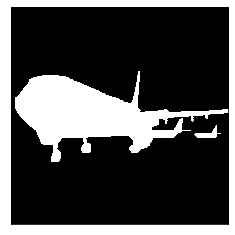

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
0


"\n    validation_data=datagen.flow_from_imageset(\n        class_mode='categorical',\n        classes=21,\n        batch_size=5,\n        shuffle=True,\n        image_set_loader=val_loader),\n    validation_steps=100,\n\nfcn_vgg16 = FCN(input_shape=(224, 224, 3), classes=21, weight_decay=3e-3,\n                weights='imagenet', trainable_encoder=True)\nfcn_vgg16.compile(optimizer=optimizer,\n                  loss='categorical_crossentropy',\n                  metrics=['accuracy'])\n\nfcn_vgg16.fit_generator(\n    datagen.flow_from_imageset(\n        class_mode='categorical',\n        classes=21,\n        batch_size=1,\n        shuffle=True,\n        image_set_loader=train_loader),\n    steps_per_epoch=1112,\n    epochs=100,\n    validation_data=datagen.flow_from_imageset(\n        class_mode='categorical',\n        classes=21,\n        batch_size=1,\n        shuffle=True,\n        image_set_loader=val_loader),\n    validation_steps=1111,\n    verbose=1,\n    callbacks=[lr_reducer, 

In [9]:
"""Pascal VOC Segmenttion Generator."""
from __future__ import unicode_literals
import os
import numpy as np
from keras import backend as K
from keras.utils.np_utils import to_categorical
import PIL.Image as pil_image
from keras.preprocessing.image import (
    ImageDataGenerator,
    Iterator,
    load_img,
    img_to_array,
    array_to_img)


class PascalVocGenerator(ImageDataGenerator):
    """A real-time data augmentation generator for PASCAL VOC2011."""

    def __init__(self,
                 image_shape=(500, 500, 3),
                 image_resample=True,
                 pixelwise_center=False,
                 pixel_mean=(0., 0., 0.),
                 pixelwise_std_normalization=False,
                 pixel_std=(1., 1., 1.),
                 featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=0.,
                 width_shift_range=0.,
                 height_shift_range=0.,
                 shear_range=0.,
                 zoom_range=0.,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=False,
                 vertical_flip=False,
                 rescale=None,
                 preprocessing_function=None,
                 data_format=None):
        """Init."""
        self.image_shape = tuple(image_shape)
        self.image_resample = image_resample
        self.pixelwise_center = pixelwise_center
        self.pixel_mean = np.array(pixel_mean)
        self.pixelwise_std_normalization = pixelwise_std_normalization
        self.pixel_std = np.array(pixel_std)
        super(PascalVocGenerator, self).__init__()

    def standardize(self, x):
        """Standardize image."""
        if self.pixelwise_center:
            x -= self.pixel_mean
        if self.pixelwise_std_normalization:
            x /= self.pixel_std
        return super(PascalVocGenerator, self).standardize(x)

    def flow_from_imageset(self, image_set_loader,
                           class_mode='categorical', classes=None,
                           batch_size=1, shuffle=True, seed=None):
        """PascalVocGenerator."""
        print("flow_from_imageset")
        return IndexIterator(
            image_set_loader, self,
            class_mode=class_mode,
            classes=classes,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed)


class IndexIterator(Iterator):
    """Iterator over index."""

    def __init__(self, image_set_loader, image_data_generator,
                 class_mode='categorical', classes=None,
                 batch_size=1, shuffle=False, seed=None):
        """Init."""
        self.image_set_loader = image_set_loader
        self.image_data_generator = image_data_generator

        self.filenames = image_set_loader.filenames
        self.image_shape = image_set_loader.image_shape

        self.classes = classes
        if class_mode == 'binary':
            label_shape = list(self.image_shape).pop(self.channel_axis - 1)
            self.label_shape = tuple(label_shape)
        elif class_mode == 'categorical':
            label_shape = list(self.image_shape)
            label_shape[self.image_data_generator.channel_axis - 1] \
                = self.classes
            self.label_shape = tuple(label_shape)
        #print(self.label_shape)
        super(IndexIterator, self).__init__(len(self.filenames), batch_size,
                                            shuffle, seed)
    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros(
            (self.batch_size,) + self.image_shape,
            dtype=K.floatx())
        batch_y = np.zeros(
            (self.batch_size,) + self.label_shape,
            dtype=np.int8)

        for i, j in enumerate(index_array):
            fn = self.filenames[j]
            x = self.image_set_loader.load_img(fn)
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x
            y = self.image_set_loader.load_seg(fn)
            y = to_categorical(y, self.classes).reshape(self.label_shape)
            # y = np.reshape(y, (-1, self.classes))
            batch_y[i] = y
        return batch_x, batch_y
        
    def next(self):
        """Next batch."""
        with self.lock:
            index_array= next(
                self.index_generator)
            print(index_array)
        batch_x = np.zeros(
            (self.batch_size,) + self.image_shape,
            dtype=K.floatx())
        batch_y = np.zeros(
            (self.batch_size,) + self.label_shape,
            dtype=np.int8)
        #batch_y = np.reshape(batch_y, (current_batch_size, -1, self.classes))
        
        for i, j in enumerate(index_array):
            fn = self.filenames[j]
            x = self.image_set_loader.load_img(fn)
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x
            y = self.image_set_loader.load_seg(fn)
            y = to_categorical(y, self.classes).reshape(self.label_shape)
            #y = np.reshape(y, (-1, self.classes))
            batch_y[i] = y

        # save augmented images to disk for debugging
        #if self.image_set_loader.save_to_dir:
        #    for i in range(current_batch_size):
        #        x = batch_x[i]
        #        y = batch_y[i].argmax(
        #            self.image_data_generator.channel_axis - 1)
        #        if self.image_data_generator.data_format == 'channels_first':
        #            y = y[np.newaxis, ...]
        #        else:
        #            y = y[..., np.newaxis]
        #        self.image_set_loader.save(x, y, current_index + i)
        #utils.showSingleImage(batch_y[0,:,:,0])
        #print(batch_y.shape)
        return batch_x, batch_y


class ImageSetLoader(object):
    """Helper class to load image data into numpy arrays."""

    def __init__(self, image_set, image_dir, label_dir, target_size=(500, 500),
                 image_format='jpg', color_mode='rgb', label_format='png',
                 data_format=None,
                 save_to_dir=None, save_prefix='', save_format='jpg'):
        """Init."""
        if data_format is None:
            data_format = K.image_data_format()
        self.data_format = data_format
        self.target_size = tuple(target_size)

        if not os.path.exists(image_set):
            raise IOError('Image set {} does not exist. Please provide a'
                          'valid file.'.format(image_set))
        self.filenames = np.loadtxt(image_set, dtype=bytes)
        try:
            self.filenames = [fn.decode('utf-8') for fn in self.filenames]
        except AttributeError as e:
            print(str(e), self.filenames[:5])
        if not os.path.exists(image_dir):
            raise IOError('Directory {} does not exist. Please provide a '
                          'valid directory.'.format(image_dir))
        self.image_dir = image_dir
        if label_dir and not os.path.exists(label_dir):
            raise IOError('Directory {} does not exist. Please provide a '
                          'valid directory.'.format(label_dir))
        self.label_dir = label_dir

        white_list_formats = {'png', 'jpg', 'jpeg', 'bmp'}
        self.image_format = image_format
        if self.image_format not in white_list_formats:
            raise ValueError('Invalid image format:', image_format,
                             '; expected "png", "jpg", "jpeg" or "bmp"')
        self.label_format = label_format
        if self.label_format not in white_list_formats:
            raise ValueError('Invalid image format:', label_format,
                             '; expected "png", "jpg", "jpeg" or "bmp"')

        if color_mode not in {'rgb', 'grayscale'}:
            raise ValueError('Invalid color mode:', color_mode,
                             '; expected "rgb" or "grayscale".')
        self.color_mode = color_mode
        if self.color_mode == 'rgb':
            if self.data_format == 'channels_last':
                self.image_shape = self.target_size + (3,)
            else:
                self.image_shape = (3,) + self.target_size
        else:
            if self.data_format == 'channels_last':
                self.image_shape = self.target_size + (1,)
            else:
                self.image_shape = (1,) + self.target_size

        self.grayscale = self.color_mode == 'grayscale'

        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format

    def load_img(self, fn):
        """Image load method.
        # Arguments
            fn: filename of the image (without extension suffix)
        # Returns
            arr: numpy array of shape self.image_shape
        """
        img_path = os.path.join(self.image_dir,
                                '{}.{}'.format(fn,
                                               self.image_format))
        if not os.path.exists(img_path):
            raise IOError('Image {} does not exist.'.format(img_path))
        #print(img_path)
        color_mode = "rgb"
        if self.grayscale:
            color_mode = "grayscale"
        img = load_img(img_path, self.grayscale, color_mode, self.target_size)
        x = img_to_array(img, data_format=self.data_format)
        #print(x.shape)
        return x

    def load_seg(self, fn):
        """Segmentation load method.
        # Arguments
            fn: filename of the image (without extension suffix)
        # Returns
            arr: numpy array of shape self.target_size
        """
        label_path = os.path.join(self.label_dir,
                                  '{}.{}'.format(fn, self.label_format))
        img = pil_image.open(label_path)
        if self.target_size:
            wh_tuple = (self.target_size[1], self.target_size[0])
        if img.size != wh_tuple:
            img = img.resize(wh_tuple)
        y = img_to_array(img, self.data_format)
        y[y == 255] = 0
        
        #print("y: ", y.shape)
        return y

    def save(self, x, y, index):
        """Image save method."""
        img = array_to_img(x, self.data_format, scale=True)
        mask = array_to_img(y, self.data_format, scale=True)
        img.paste(mask, (0, 0), mask)

        fname = 'img_{prefix}_{index}_{hash}.{format}'.format(
            prefix=self.save_prefix,
            index=index,
            hash=np.random.randint(1e4),
            format=self.save_format)
        img.save(os.path.join(self.save_to_dir, fname))

import yaml
import keras
with open("init_args.yml", 'r') as stream:
    try:
        init_args = yaml.load(stream)
    except yaml.YAMLError as exc:
        print(exc)
        
datagen = PascalVocGenerator(image_shape=[224, 224, 3],
                                    image_resample=True,
                                    pixelwise_center=True,
                                    pixel_mean=[115.85100, 110.50989, 102.16182],
                                    pixelwise_std_normalization=True,
                                    pixel_std=[70.30930, 69.41244, 72.60676])

train_loader = ImageSetLoader(**init_args['image_set_loader']['train'])
val_loader = ImageSetLoader(**init_args['image_set_loader']['val'])

val_gen = datagen.flow_from_imageset(
        class_mode='categorical',
        classes=21,
        batch_size=5,
        shuffle=False,
        image_set_loader=val_loader)
count = 0
for batch in val_gen:
    print(batch[0].shape, batch[1].shape)
    mask = batch[1][0,:,:,0]
    utils.showSingleImage(batch[1][0,:,:,0])
    print(mask)
    print(mask[112][112])
    count+=1
    if count >= 1:
        break
'''
optimizer = keras.optimizers.Adam(1e-4)
model = create_fcn32((224,224,3))
#model.summary()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(
    datagen.flow_from_imageset(
        class_mode='categorical',
        classes=21,
        batch_size=5,
        shuffle=True,
        image_set_loader=train_loader),
    steps_per_epoch=500,
    epochs=10,
    validation_data=datagen.flow_from_imageset(
        class_mode='categorical',
        classes=21,
        batch_size=5,
        shuffle=True,
        image_set_loader=val_loader),
    validation_steps=100,
    verbose=1,
    use_multiprocessing=False)

#print(train_loader.filenames)
'''

'''
    validation_data=datagen.flow_from_imageset(
        class_mode='categorical',
        classes=21,
        batch_size=5,
        shuffle=True,
        image_set_loader=val_loader),
    validation_steps=100,

fcn_vgg16 = FCN(input_shape=(224, 224, 3), classes=21, weight_decay=3e-3,
                weights='imagenet', trainable_encoder=True)
fcn_vgg16.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

fcn_vgg16.fit_generator(
    datagen.flow_from_imageset(
        class_mode='categorical',
        classes=21,
        batch_size=1,
        shuffle=True,
        image_set_loader=train_loader),
    steps_per_epoch=1112,
    epochs=100,
    validation_data=datagen.flow_from_imageset(
        class_mode='categorical',
        classes=21,
        batch_size=1,
        shuffle=True,
        image_set_loader=val_loader),
    validation_steps=1111,
    verbose=1,
    callbacks=[lr_reducer, early_stopper, csv_logger, checkpointer, nan_terminator])
'''
